In [74]:
"""
Created on Tuesday 3 April 2022
Author: ZMW
"""
#import libraries

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import *
import pickle
from numpy import mean
from numpy import std
from xgboost import plot_importance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import shap
from sklearn.metrics import log_loss

#### Reading dataset

In [86]:
# data path
path = os.getcwd()
dirname = os.path.dirname(path)
#for windown
#data_file = "data\\data.csv"
#for linux
data_file = 'data/data.csv'
data_path = os.path.join(dirname,data_file)

In [87]:
#Load the fitted dataset
data = pd.read_csv(data_path)

In [88]:
data.head()

,Label,Patient,A1_1Deg,A1_1Deg_err,B1_1Deg,B1_1Deg_err,C1_1Deg,C1_1Deg_err,1_Deg_ResSoS_1,1Deg_AdjR2_1,...,8_Deg_ResSoS_1,8Deg_AdjR2_1,A2_8Deg,A2_8Deg_err,B2_8Deg,B2_8Deg_err,C2_8Deg,C2_8Deg_err,8_Deg_ResSoS_2,8Deg_AdjR2_2
0,Not_Parkinson's,PD001,10.388190,0.006132,0.049329,0.000006,0.011989,0.000337,8928.709194,0.990598,...,6698.838281,0.951413,10.273124,0.044206,0.386347,0.000384,0.037356,0.002439,6809.455800,0.939095
1,Not_Parkinson's,PD002,10.429055,0.006929,0.049478,0.000007,0.002837,0.000379,11388.604704,0.988092,...,4769.901822,0.967360,11.482500,0.049154,0.395412,0.000380,-0.002486,0.002419,8383.481840,0.939586
2,Not_Parkinson's,PD003,10.097088,0.005091,0.049368,0.000006,0.005707,0.000287,6140.292312,0.993141,...,3488.747176,0.968709,10.084338,0.019838,0.394595,0.000174,-0.035466,0.001106,1349.962240,0.987259
3,Not_Parkinson's,PD004,10.482881,0.022179,0.049585,0.000023,0.016056,0.001212,117748.979710,0.879372,...,10972.045844,0.920137,11.493414,0.048867,0.401386,0.000377,-0.042463,0.002395,8242.136178,0.940370
4,Not_Parkinson's,PD005,10.181273,0.008833,0.049368,0.000010,0.001569,0.000494,18447.340517,0.979692,...,18268.960666,0.809586,10.370348,0.036121,0.395392,0.000308,-0.030769,0.001960,4485.300264,0.960035


In [89]:
# Features and labels
x = data.iloc[:,2:]
y = data.iloc[:,0]

In [92]:
# Standardization
sc = StandardScaler()
x = pd.DataFrame(sc.fit_transform(data.iloc[:,2:]),index=data.iloc[:,2:].index, columns= data.iloc[:,2:].columns)

In [94]:
## Convert the categorical variables to number
LabelEncoder_gender = LabelEncoder()
y = LabelEncoder_gender.fit_transform(y)

In [95]:
# spliting feature
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

### Baseline model

In [97]:
# StratifiedKFold
# create stratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
rf_accu_stratified = []

# Feature Scaling for input features
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)

# create classifier objects
model = RandomForestClassifier()
for train_index, test_index in skf.split(x,y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model.fit(x_train_fold, y_train_fold)
    rf_accu_stratified.append(model.score(x_test_fold, y_test_fold))

print('RF based model accuracy score: {0:0.4f}'.format(mean(rf_accu_stratified)),'+/-',std(rf_accu_stratified))

#print("RF based model accuracy score: {0:0.4f}".format(all_run_df['acc'].mean()))

RF based model accuracy score: 0.5833 +/- 0.2006932429798716


### Hyperparameter tuning

In [98]:
# parameter list
n_estimators_list = [10, 50, 100, 200, 300, 400,500]
max_depth_list = range(3, 12)
min_samples_leaf_list = [1, 3, 5, 10, 20, 50]
max_features_list = ['sqrt', 'log2', 0.7, 0.8, 0.9]
min_samples_split_list = [2, 5, 10]

In [99]:
# parameters
params= {'n_estimators': hp.choice('n_estimators', [10,50,100,300,400,500]),
          'max_depth': hp.choice('max_depth', range(3, 12)),
          'min_samples_leaf': hp.choice('min_samples_leaf', [1, 3, 5, 10, 20, 50]),
          'min_samples_split':hp.choice('min_samples_split',[2,5,10]),
          'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 0.01),
          'max_features': hp.choice('max_features', ['sqrt', 'log2', 0.7, 0.8, 0.9])
          }

In [100]:
# Hyperparameter Tuning function
def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
#   print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }


In [101]:
# Optimizing
trials = Trials()

best_hyperparams = fmin(fn = hyperparameter_tuning,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

100%|██████████| 50/50 [00:08<00:00,  5.61trial/s, best loss: -0.8888888888888888]


In [102]:
# Model with tuned parameters
best_model = RandomForestClassifier(n_estimators=n_estimators_list[best_hyperparams['n_estimators']],
                                    max_depth=max_depth_list[best_hyperparams['max_depth']],
                                    min_samples_leaf=min_samples_leaf_list[best_hyperparams['min_samples_leaf']],
                                    min_samples_split = min_samples_split_list[best_hyperparams['min_samples_split']],
                                    max_features=max_features_list[best_hyperparams['max_features']],
                                    min_impurity_decrease=best_hyperparams['min_impurity_decrease'],
                                    n_jobs=-1, random_state=1, verbose=0)

### Save best model

In [103]:
#save
file_name = 'hyper_rf.pkl'
pickle.dump(best_model, open(file_name,'wb'))

### Load best model

In [104]:
#save
file_name = 'hyper_rf.pkl'
#pickle.dump(best_model, open(file_name,'wb'))

#load
rf_hyper = pickle.load(open(file_name,'rb'))

In [105]:
# KFold
all_run = []
for split in range(30):
    #cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=split)
    kfold = KFold(n_splits=4, shuffle=True,random_state=split)
    scores = cross_val_score(rf_hyper,x,y,scoring='roc_auc', cv=kfold)
    result = [[split,scores.mean()]]
    all_run += result
#print(all_run)
all_run_df = pd.DataFrame(all_run,columns=['split','acc'])
print(all_run_df['acc'].mean(),all_run_df['acc'].std())

0.7077430555555557 0.09683489441941387


In [106]:
# create stratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
rf_accu_stratified = []

# Feature Scaling for input features
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)

for train_index, test_index in skf.split(x,y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    rf_hyper.fit(x_train_fold, y_train_fold)
    rf_accu_stratified.append(rf_hyper.score(x_test_fold, y_test_fold))

print('RF model with tuned parameters accuracy score: {0:0.4f}'.format(mean(rf_accu_stratified)))

#print("RF based model accuracy score: {0:0.4f}".format(all_run_df['acc'].mean()))

RF model with tuned parameters accuracy score: 0.6167


### Feature importance

In [51]:
# Kfold
data = data[['Label','Patient','C1_8Deg','C2_1Deg','C1_2Deg','C2_6Deg',
            'B2_2Deg','B1_6Deg','A1_2Deg','C2_8Deg','A2_8Deg','B1_6Deg']]
# data = data[['Label','Patient','B2_6Deg','C2_1Deg','C1_2Deg','C1_8Deg',
#             'C2_6Deg','A1_4Deg','A1_6Deg','A1_2Deg','B2_2Deg','B1_6Deg']]

# data = data[['Label','Patient','C1_8Deg','C2_1Deg','C2_6Deg','C1_2Deg',
#             'B2_2Deg','B2_6Deg','A1_2Deg','B1_6Deg','A1_6Deg','A1_4Deg']]
x = data.iloc[:,2:]
# sc = StandardScaler()
# x = sc.fit_transform(x)
y = data.iloc[:,0]
y = LabelEncoder_gender.fit_transform(y)
# x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
# best_model.fit(x_train, y_train)
#best_model.fit(x,y,eval_metric='auc')
all_run = []
for split in range(30):
    #cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=split)
    kfold = KFold(n_splits=4, shuffle=True,random_state=split)
    scores = cross_val_score(rf_hyper,x,y,scoring='roc_auc', cv=kfold)
    result = [[split,scores.mean()]]
    all_run += result
#print(all_run)
all_run_df = pd.DataFrame(all_run,columns=['split','acc'])
print(all_run_df['acc'].mean(),all_run_df['acc'].std())

0.8081597222222222 0.07711103655905142


In [107]:
data = data[['Label','Patient','C1_8Deg','C2_1Deg','C2_6Deg','C1_2Deg',
            'B2_2Deg','B2_6Deg','A1_2Deg','B1_6Deg','A1_6Deg','A1_4Deg']]
x = data.iloc[:,2:]
# sc = StandardScaler()
# x = sc.fit_transform(x)
y = data.iloc[:,0]
y = LabelEncoder_gender.fit_transform(y)
# spliting feature
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
# Hyperparameter Tuning function
def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
#   print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [108]:
# Optimizing
trials = Trials()

best_hyperparams = fmin(fn = hyperparameter_tuning,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

100%|██████████| 50/50 [00:09<00:00,  5.38trial/s, best loss: -1.0]               


In [109]:
# Model with tuned parameters
best_model = RandomForestClassifier(n_estimators=n_estimators_list[best_hyperparams['n_estimators']],
                                    max_depth=max_depth_list[best_hyperparams['max_depth']],
                                    min_samples_leaf=min_samples_leaf_list[best_hyperparams['min_samples_leaf']],
                                    min_samples_split = min_samples_split_list[best_hyperparams['min_samples_split']],
                                    max_features=max_features_list[best_hyperparams['max_features']],
                                    min_impurity_decrease=best_hyperparams['min_impurity_decrease'],
                                    n_jobs=-1, random_state=1, verbose=0)

#### Save Stratified latest model

In [110]:
file_name = 'hyper_stra_rf.pkl'
pickle.dump(best_model, open(file_name,'wb'))

#### Load the model

In [111]:
#save
file_name = 'hyper_stra_rf.pkl'
#pickle.dump(best_model, open(file_name,'wb'))

#load
rf_hyper = pickle.load(open(file_name,'rb'))

In [112]:

skf = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1)
rf_accu_stratified = []

# Feature Scaling for input features
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)

for train_index, test_index in skf.split(x,y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    rf_hyper.fit(x_train_fold, y_train_fold)
    rf_accu_stratified.append(rf_hyper.score(x_test_fold, y_test_fold))

print('RF model with feature importance accuracy score: {0:0.4f}'.format(mean(rf_accu_stratified)), std(rf_accu_stratified))

RF model with feature importance accuracy score: 0.7833 0.23629078131263043


#### Confusion matrix

In [113]:
rf_hyper.fit(x_train, y_train)
y_pred = rf_hyper.predict(x_test)
predictions = [round(value) for value in y_pred]

# Accuracy
accuracy = roc_auc_score(y_test,predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.00%


In [114]:
#confusion matrix
confusion = confusion_matrix(y_test,predictions)
print(confusion)

#  Sensitivity 
TP = confusion[1,1] # true positives
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # False positives
FN = confusion[1,0] # false negatives

sensitivity = TP/float(TP+FN)
print(sensitivity)

# Specificity
specificity = TN/float(TN+FP)
print(specificity)


auc_score = roc_auc_score(y_test,predictions)
fpr , tpr , thresholds = roc_curve (y_test, predictions)
print(auc_score)

[[4 0]
 [1 4]]
0.8
1.0
0.9


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


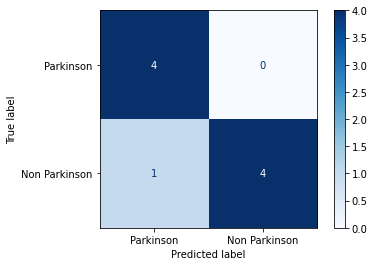

In [115]:
class_names = ['Parkinson','Non Parkinson']
disp = plot_confusion_matrix(rf_hyper, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

#plt.savefig('cm.png',dpi=300)
plt.show()

#### Learning Curve

/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/zaw/miniforge3/envs

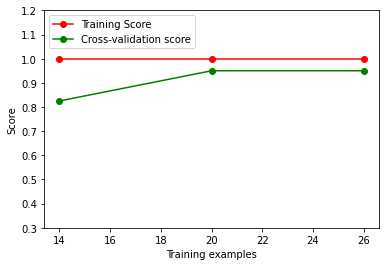

<module 'matplotlib.pyplot' from '/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [89]:
def plot_learning_curve(estimator, x,y, ax=None, ylim=(0.3, 1.2), cv=None, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, x, y, cv=cv,n_jobs = n_jobs, train_sizes= train_sizes,scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis= 1)
    test_scores_std   = np.std(test_scores, axis=1 )

    # plot learning curve
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.plot(train_sizes, train_scores_mean, 'o-', color='r', label ='Training Score')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    ax.legend(loc='upper left')
    plt.show()

    return plt

fig, ax = plt.subplots(1, 1)
skf = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1)
estimator = rf_hyper
plot_learning_curve(estimator, x, y, ax = ax, cv=skf, train_sizes=np.linspace(.1, 1.0, 5))
        

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "

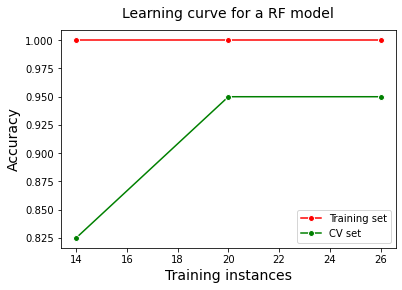

In [54]:
train_sizes=np.linspace(.1, 1.0, 5)
skf = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1)
train_sizes, train_scores, validation_scores = learning_curve(estimator = rf_hyper #xgb.XGBClassifier(n_estimators=n_estimators_ls[best_hyperparams['n_estimators']],
                            #    max_depth=max_depth_ls[best_hyperparams['max_depth']],
                            #    min_child_weight=min_child_weight_ls[best_hyperparams['min_child_weight']],
                            #    learning_rate=best_hyperparams['learning_rate'],
                            #    gamma=best_hyperparams['gamma'],
                            #    subsample=best_hyperparams['subsample'],
                            #    colsample_bytree=best_hyperparams['colsample_bytree'],
                            #    n_jobs=6, random_state=1, seed=1),
                               
                            ,X = x_scaled, y = y, train_sizes = train_sizes,
                            cv = skf,scoring = 'roc_auc')


train_scores_mean =  train_scores.mean(axis=1)
#train_scores_std =  train_scores.std(axis=1)

validation_scores_mean =  validation_scores.mean(axis = 1)
#validation_scores_std = validation_scores.std(axis=1)


fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores_mean,"o-",markeredgecolor='white', label = 'Training set',color='r')

ax.plot(train_sizes, validation_scores_mean, "o-",markeredgecolor='w', label = 'CV set',color='g')
#ax.set_xticks([0,331,662,993,1324,1656])
#ax.set_xticklabels([0,20,40,60,80,100,])
ax.set_ylabel('Accuracy', fontsize = 14)
ax.set_xlabel('Training instances', fontsize = 14)
ax.set_title('Learning curve for a RF model', fontsize = 14, y = 1.03)
ax.legend()
#plt.savefig(dirname+"/logP/results/mlp_lc.png", format='png', dpi=600)
plt.show()

# Learning curve